In [ ]:
from torchvision.datasets import Food101

1. 주제 선택 및 문제 정의

이 프로젝트는 Food-101 데이터셋을 사용하여 음식 이미지를 분류하는 CNN(합성곱 신경망) 모델을 만드는 것을 목표로 한다.
Food-101 데이터셋은 101가지 음식 종류로 구성되어 있으며, 총 101,000장의 음식 이미지가 포함되어 있다.

문제 정의

본 프로젝트의 목표는 음식 사진을 입력으로 받아,
해당 이미지가 어떤 음식인지 맞히는 프로그램을 만드는 것이다.
(예: 피자, 라면, 비빔밥, 스시, 스테이크 등)

Food-101 데이터셋은 다음과 같은 특징을 가진다.

같은 음식이라도 모양이나 색이 다양함

서로 다른 음식이 비슷하게 보이는 경우가 있음

사진 촬영 환경(조명, 각도, 배경)이 서로 다름

이러한 이유로 Food-101 데이터셋은 이미지 분류 연습용 데이터셋으로 많이 사용된다.

연구 질문

이 프로젝트에서는 다음과 같은 질문을 중심으로 실험을 진행하였다.

기본적인 CNN 모델은 Food-101 데이터셋에서 어느 정도의 성능을 보이는가?

ResNet18과 전이 학습을 사용하면 성능이 좋아지는가?

데이터 증강을 사용하면 모델의 성능에 도움이 되는가?

모델이 잘 구분하지 못하는 음식 종류는 무엇인가?

In [ ]:
!pip install torch torchvision --quiet
import torch
from torchvision.datasets import Food101
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
train_data_full = Food101(root="./data", split="train", transform=transform_train, download=True)
test_data = Food101(root="./data", split="test", transform=transform_test, download=True)

len(train_data_full), len(test_data)


100%|██████████| 5.00G/5.00G [03:47<00:00, 22.0MB/s]


(75750, 25250)

In [ ]:
train_size = int(0.7 * len(train_data_full))
val_size = len(train_data_full) - train_size

train_data, val_data = random_split(train_data_full, [train_size, val_size])

len(train_data), len(val_data)


(53025, 22725)

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

        # Automatically calculate fc input size
        self._init_fc()

        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, 101)

    def _init_fc(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 160, 160)  # <-- Image size to match the transform now
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.flatten(x)
            self.flatten_size = x.shape[1]  # auto calculate

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



baseline_model = BaselineCNN().to(device)
baseline_model


BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=51200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=101, bias=True)
)

In [ ]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Accumulated by batch size
        total_loss += loss.item() * images.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    # Average by total number of datasets
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)

baseline_train_loss = []
baseline_val_loss = []
baseline_train_acc = []
baseline_val_acc = []

EPOCHS = 2

for epoch in range(EPOCHS):
    train_loss, train_acc = train(baseline_model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(baseline_model, val_loader, criterion)

    baseline_train_loss.append(train_loss)
    baseline_val_loss.append(val_loss)
    baseline_train_acc.append(train_acc)
    baseline_val_acc.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


[Epoch 1] Train Acc: 0.0103, Val Acc: 0.0086
[Epoch 2] Train Acc: 0.0105, Val Acc: 0.0090


2. 모델 설계 및 구현 – 성능 개선 모델 (ResNet18)

모델의 성능을 높이기 위해 ResNet18 모델을 사용하였다.
ResNet18은 ImageNet 데이터셋으로 미리 학습된(pre-trained) 모델이며,
마지막 출력층을 Food-101 데이터셋에 맞게 101개 클래스로 수정하여 사용하였다.

학습 과정에서는 다음과 같은 설정을 사용하였다.

사전 학습된 가중치를 사용한 전이 학습(Transfer Learning)

최종 분류층을 101개의 음식 클래스로 변경

옵티마이저: Adam

학습률(Learning Rate): 0.0001

배치 크기(Batch Size): 16

모든 층을 함께 미세 조정(Fine-tuning)

학습 결과

3 에폭(epoch) 학습 후, ResNet18 모델은 다음과 같은 성능을 보였다.

학습 정확도(Train Accuracy): 약 63.6%

검증 정확도(Validation Accuracy): 약 60.7%

이는 기본 CNN 모델의 정확도(약 1%)와 비교했을 때 매우 큰 성능 향상이다.

성능이 향상된 이유

ResNet18 모델이 높은 성능을 보인 이유는 다음과 같다.

기본 CNN보다 훨씬 깊은 구조를 가지고 있음

잔차 연결(Residual Connection)을 사용하여 학습이 안정적임

ImageNet으로 학습된 유용한 특징을 이미 가지고 있음

데이터 증강(좌우 반전, 회전, 색상 변화)을 사용하여 일반화 성능을 향상시킴

In [ ]:
print("baseline_model device:", next(baseline_model.parameters()).device)
print("train batch example:", next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)


baseline_model device: cuda:0
train batch example: torch.Size([16, 3, 160, 160]) torch.Size([16])


In [ ]:
from torchvision import models

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 101)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


3. 모델 설계 및 구현 – 기본 CNN 모델

기본 모델로 간단한 합성곱 신경망(CNN)을 구현하였다.
이 모델은 총 세 개의 합성곱 층으로 구성되어 있으며, 각 층 뒤에 맥스 풀링을 적용하였다.
마지막에는 두 개의 완전 연결층을 사용하여 분류를 수행하였다.

모든 입력 이미지는 160×160 크기로 변환한 후, ImageNet에서 사용되는 평균과 표준편차를 이용해 정규화하였다.
모델은 Food-101 학습 데이터셋을 사용하여 처음부터 학습하였다.

학습 설정은 다음과 같다.
옵티마이저는 Adam을 사용하였고, 학습률은 0.001로 설정하였다.
배치 크기는 16으로 설정하였다.

2 에폭 학습 후, 기본 CNN 모델의 성능은 다음과 같았다.

학습 정확도는 약 1.0%였고, 검증 정확도는 약 0.9%였다.

Food-101 데이터셋은 총 101개의 클래스로 구성되어 있기 때문에, 무작위로 예측할 경우 약 1%의 정확도가 나온다.
따라서 기본 CNN 모델의 성능은 거의 랜덤 예측과 비슷하며, 이는 모델이 데이터의 특징을 충분히 학습하지 못한 과소적합 상태임을 의미한다.

이 기본 모델은 이후에 사용한 ResNet18 모델과의 성능 차이를 비교하기 위한 기준 모델로 사용하였다.

In [ ]:
res_train_loss = []
res_val_loss = []
res_train_acc = []
res_val_acc = []

EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss, train_acc = train(resnet, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(resnet, val_loader, criterion)

    res_train_loss.append(train_loss)
    res_val_loss.append(val_loss)
    res_train_acc.append(train_acc)
    res_val_acc.append(val_acc)

    print(f"[Epoch {epoch+1}] ResNet Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


[Epoch 1] ResNet Train Acc: 0.4171, Val Acc: 0.5380
[Epoch 2] ResNet Train Acc: 0.5722, Val Acc: 0.5826
[Epoch 3] ResNet Train Acc: 0.6362, Val Acc: 0.6068


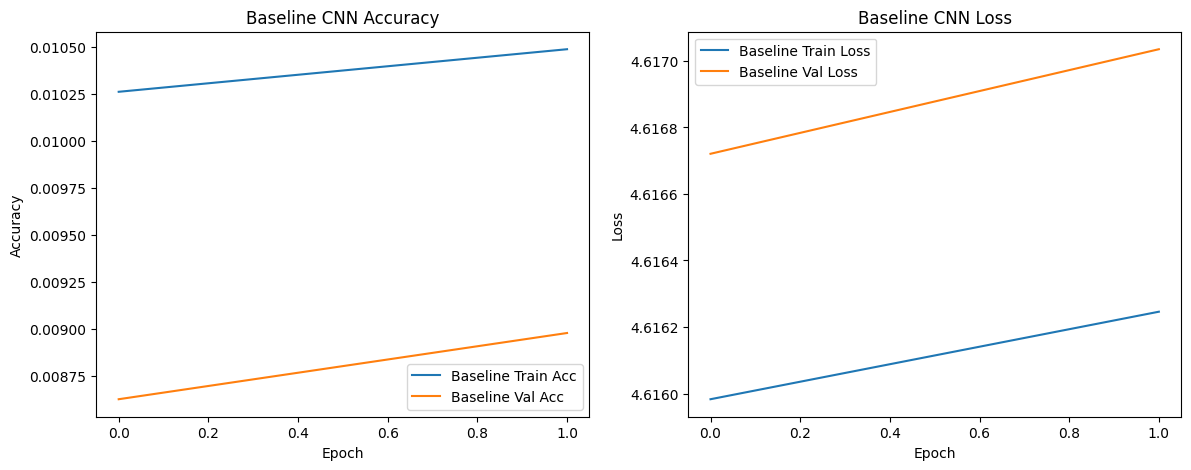

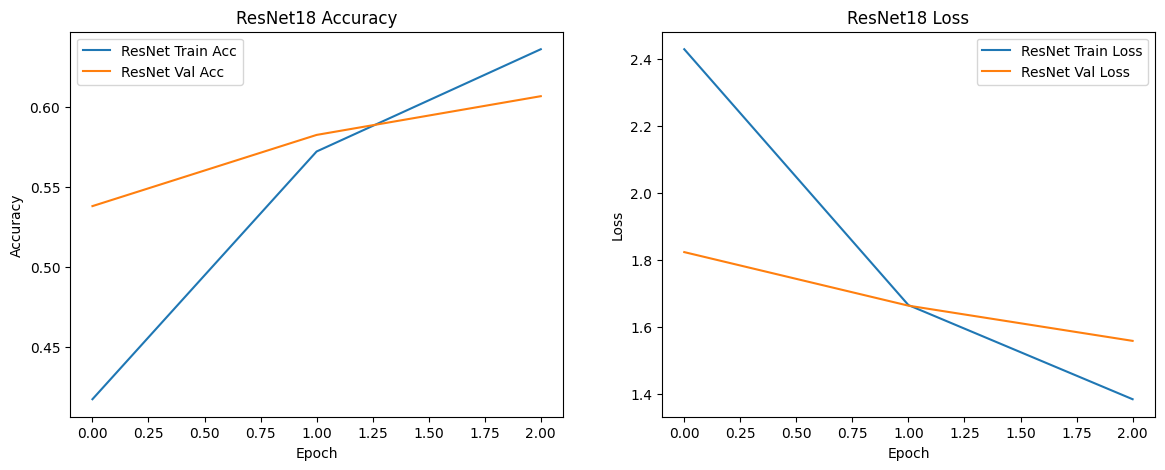

In [ ]:
import matplotlib.pyplot as plt

# Baseline
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(baseline_train_acc, label="Baseline Train Acc")
plt.plot(baseline_val_acc, label="Baseline Val Acc")
plt.title("Baseline CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(baseline_train_loss, label="Baseline Train Loss")
plt.plot(baseline_val_loss, label="Baseline Val Loss")
plt.title("Baseline CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# ResNet18
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(res_train_acc, label="ResNet Train Acc")
plt.plot(res_val_acc, label="ResNet Val Acc")
plt.title("ResNet18 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_train_loss, label="ResNet Train Loss")
plt.plot(res_val_loss, label="ResNet Val Loss")
plt.title("ResNet18 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


4. 평가 및 분석 – 학습 곡선 분석

학습 곡선을 통해 기본 CNN 모델과 ResNet18 모델의 차이를 확인할 수 있었다.

먼저 기본 CNN 모델의 경우, 학습 정확도와 검증 정확도가 모두 약 1% 수준에서 거의 변하지 않았다.
손실 값 또한 학습이 진행되어도 크게 감소하지 않았다.
이는 모델이 Food-101 데이터셋에서 의미 있는 특징을 충분히 학습하지 못하고 있으며, 심한 과소적합 상태에 있음을 보여준다.

반면 ResNet18 모델의 경우, 학습이 진행됨에 따라 성능이 꾸준히 향상되었다.
학습 정확도는 약 41.7%에서 63.6%까지 증가하였고, 검증 정확도 역시 약 53.8%에서 60.7%까지 상승하였다.
학습 곡선과 검증 곡선이 비슷한 형태로 증가하는 모습을 보였으며, 이는 학습 초반 단계에서 과적합이 크지 않고 비교적 잘 일반화되고 있음을 의미한다.

이러한 결과를 통해 전이 학습을 적용한 ResNet18 모델은 Food-101 데이터셋에 매우 효과적임을 확인할 수 있었으며, 기본 CNN 모델은 해당 데이터셋을 처리하기에는 구조적으로 성능이 부족하다는 점을 알 수 있었다.

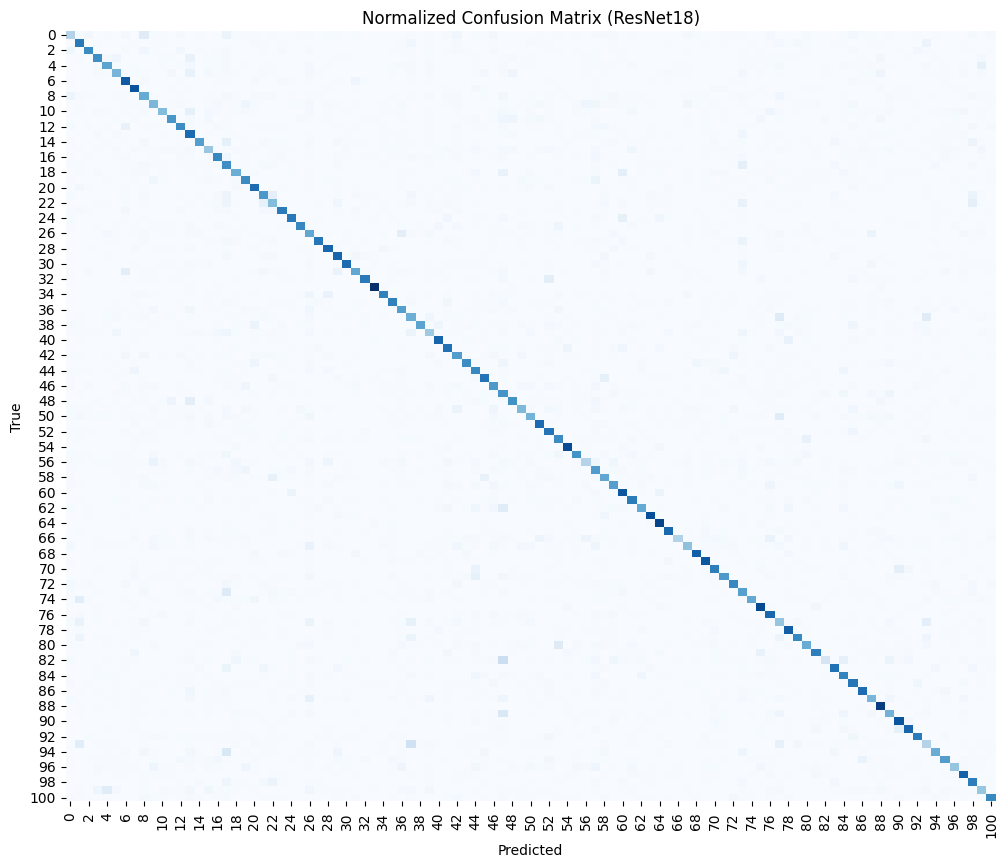

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# all predict collect
all_preds = []
all_labels = []

resnet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = resnet(images)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, cmap="Blues", cbar=False)
plt.title("Normalized Confusion Matrix (ResNet18)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


4. 평가 및 분석 – 혼동 행렬 분석

정규화된 혼동 행렬을 통해 모델이 어떤 음식들을 헷갈려 하는지 확인할 수 있었다.

분석 결과, 다음과 같은 특징이 관찰되었다.

먼저 시각적으로 비슷한 음식들끼리 오분류가 자주 발생하였다.
예를 들어, 서로 다른 종류의 면 요리나 튀김 음식들은 서로 다른 클래스임에도 불구하고 자주 혼동되었다.

또한 색감이나 담는 방식이 비슷한 음식들, 예를 들어 여러 종류의 밥 요리 역시 서로 잘 구분되지 않는 경향을 보였다.

반면 피자나 햄버거처럼 모양이나 색이 뚜렷한 음식들은 비교적 높은 정확도로 분류되었다.

이러한 결과를 통해 모델이 주로 음식의 질감, 색상, 전체적인 형태와 같은 시각적 특징에 의존하고 있음을 알 수 있었다.
두 음식 클래스가 비슷한 시각적 특징을 공유할수록, 모델이 이를 구분하지 못하고 잘못 분류할 가능성이 높아진다는 점을 확인하였다.

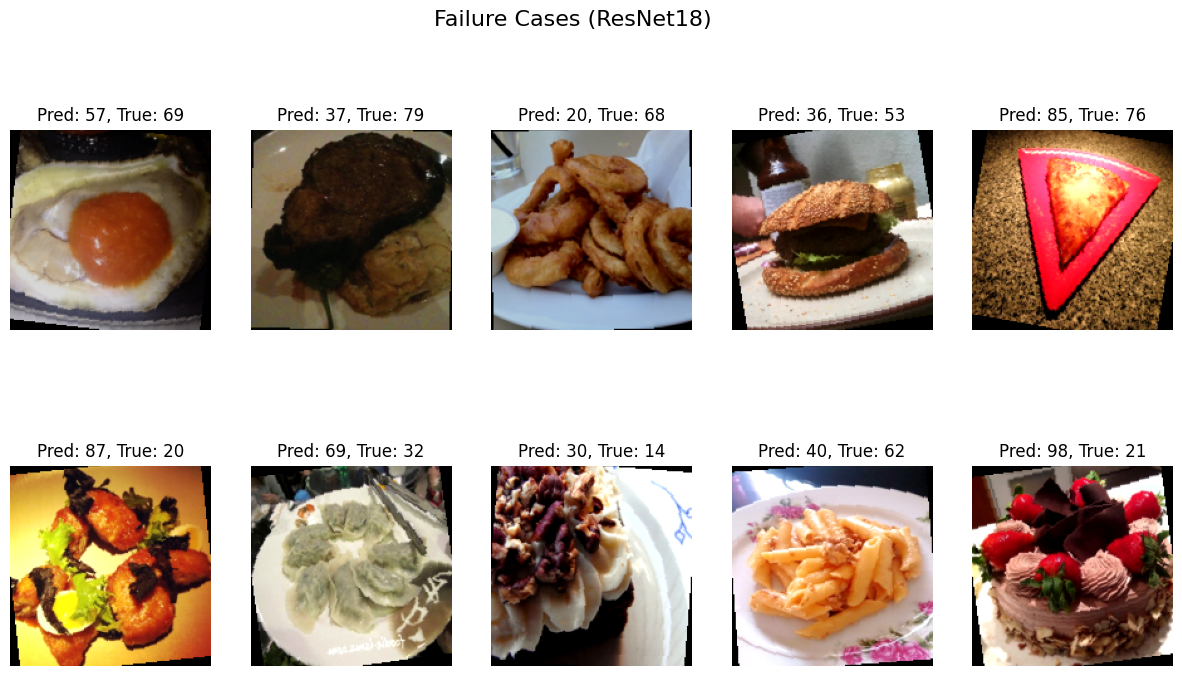

In [ ]:
import matplotlib.pyplot as plt
import torch

# De-normalize func
def denorm(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean   # Normalize Reversing

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)

    img = denorm(mis_images[i])   # reverse normalization
    img = img.permute(1,2,0).clip(0,1)  # 0~1 range clipping

    plt.imshow(img)
    plt.title(f"Pred: {mis_preds[i]}, True: {mis_labels[i]}")
    plt.axis("off")

plt.suptitle("Failure Cases (ResNet18)", fontsize=16)
plt.show()


4. 평가 및 분석 – 실패 사례 분석

모델의 한계를 더 잘 이해하기 위해, 검증 데이터 중에서 잘못 분류된 이미지 10장을 시각화하여 분석하였다.
대표적인 실패 사례는 다음과 같다.

첫째, 조명과 색상 변화로 인한 오류가 많이 발생하였다.
강한 노란색이나 붉은 조명이 있는 경우, 음식의 실제 색이 변해 보이면서 다른 음식으로 잘못 분류되는 경우가 있었다.

둘째, 배경이 복잡한 이미지에서 오분류가 자주 나타났다.
접시, 테이블, 주변 물체 등이 음식보다 더 눈에 띄는 경우, 모델이 음식의 형태를 제대로 인식하지 못하는 문제가 발생하였다.

셋째, 음식의 형태가 매우 다양한 경우에도 분류 오류가 많았다.
예를 들어 튀김 요리나 여러 재료가 섞인 음식은 모양이 일정하지 않아, 시각적으로 비슷한 다른 음식과 혼동되는 경우가 있었다.

이러한 사례를 통해 모델이 조명, 배경, 그리고 같은 클래스 내의 다양한 외형 변화에 민감하다는 점을 확인할 수 있었다.
이러한 요소들에 대한 강인함을 개선한다면 모델의 정확도를 더 높일 수 있을 것으로 보인다.

5. 결론

본 미니 프로젝트에서는 Food-101 데이터셋을 사용하여 두 가지 CNN 모델을 학습하고 성능을 비교하였다.

기본 CNN 모델은 약 1%의 정확도를 보였으며, 이는 101개의 클래스 중에서 무작위로 예측하는 것과 거의 비슷한 수준이다.
이를 통해 간단한 구조의 모델은 Food-101과 같은 복잡한 데이터셋을 학습하기에 충분하지 않으며, 과소적합 문제가 발생함을 확인할 수 있었다.

반면 ImageNet으로 사전 학습된 ResNet18 모델을 전이 학습 방식으로 사용한 경우, 단 3 에폭의 학습만으로도 약 60%의 검증 정확도를 달성하였다.
이는 복잡한 이미지 분류 문제에서 깊은 구조의 사전 학습 모델이 매우 효과적임을 보여준다.

전체 실험 결과를 통해, Food-101과 같은 대규모 이미지 데이터셋에서는 모델의 복잡도, 사전 학습의 활용, 그리고 데이터 증강이 성능에 중요한 영향을 미친다는 점을 확인할 수 있었다.

향후 연구 방향으로는 다음과 같은 개선을 고려할 수 있다.

ResNet50이나 EfficientNet과 같은 더 깊은 모델 사용

학습 횟수를 늘리고 학습률 조정 기법 적용

Mixup이나 CutMix와 같은 더 강한 데이터 증강 기법 사용

클래스 불균형을 고려한 가중치 손실 함수 적용